# Fault Diagnosis using Deep Learning on raw time domain data
In this post we will apply deep learning to CWRU data set. We will apply a standard convolutional neural network (CNN) architecture to raw vibration data. The data used in this experiment can be downloaded from the link mentioned below.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

2025-02-14 19:31:54.268471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 19:31:56.695815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-14 19:31:56.695964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-14 19:31:56.695974: W tensorflow/compiler/tf2tensorrt/util

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.11.1
Numpy version:  1.26.4
Pandas version:  2.0.3
Scikit-learn version:  1.3.2


## Data
We have used CWRU data for this demonstration. It is a standard database used in condition monitoring applications. We have used the drive end data that are sampled at 48 kHz sampling frequency when load of 1 hp is applied on the shaft. Normal data collected with 1 hp load have also been used. There are a total of 10 classes. The classes are

* C1  : Ball defect (0.007 inch, load: 1 hp)
* C2  : Ball defect (0.014 inch, load: 1 hp)
* C3  : Ball defect (0.021 inch, load: 1 hp)
* C4  : Inner race fault (0.007 inch, load: 1 hp)
* C5  : Inner race fault (0.014 inch, load: 1 hp)
* C6  : Inner race fault (0.021 inch, load: 1 hp)
* C7  : Normal (load: 1 hp)
* C8  : Outer race fault (0.007 inch, load: 1 hp, data collected from 6 O'clock position)
* C9  : Outer race fault (0.014 inch, load: 1 hp, 6 O'clock)
* C10 : Outer race fault (0.021 inch, load: 1 hp, 6 O'clock)

From each category data are collected in segments of length 1024 and resized to a 2-D matrix of size (32 by 32). There is no overlap between segments. For each category 460 such segments are taken. Total size of the data thus becomes (4600, 32, 32). Out of this 1000 segments are randomly chosen as test data and rest are used for training. Readers can directly download the data from the link mentioned below.

[Download the data from here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/CWRU_48k_load_1_CNN_data.npz). Another convenient way is to [download the whole repository](https://codeload.github.com/biswajitsahoo1111/cbm_codes_open/legacy.zip/master) and run the downloaded notebooks.

(**Note**: In the original data of CWRU, inner race fault of 0.014 inch with sampling frequency of 48 kHz and load of 1 hp is stored as a file named '175.mat'. Inside this file there are following sub fields:
            
            X217: [489125×2 double]
    X217_DE_time: [489125×1 double]
    X175_DE_time: [381890×1 double]
    X175_FE_time: [381890×1 double]
         X175RPM: 1772
         
The file 'X175_DE_time' has less data points. From it we can't extract 460 segments of length 1024 without overlap. So we have used 'X217_DE_time' instead as our 0.014 inch outer race fault data. From this file 460 segments can be extracted. In the 'numpy' file this data is used for 'IR_014' category. For all other categories respective drive end data are used.)

In [3]:
# Run the notebook after cloning the repo
file = np.load('data/CWRU_48k_load_1_CNN_data.npz') # Give path to downloaded file in your system
print(file.files)

['data', 'labels']


In [4]:
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [5]:
print(data[0])
print(labels)

[[-0.041097  -0.046104  -0.028372  ... -0.042975  -0.11453   -0.17711  ]
 [-0.23052   -0.26348   -0.26077   ... -0.023782  -0.11787   -0.18775  ]
 [-0.20882   -0.19297   -0.15208   ... -0.017524  -0.063628  -0.11411  ]
 ...
 [ 0.02253   -0.049859  -0.11098   ... -0.036508  -0.03317   -0.02858  ]
 [-0.0031292  0.030249   0.063419  ... -0.035882  -0.010014   0.030875 ]
 [ 0.06029    0.072598   0.076145  ...  0.13602    0.10139    0.066548 ]]
['Ball_007' 'Ball_007' 'Ball_007' ... 'Normal' 'Normal' 'Normal']


In [6]:
category_labels = np.unique(labels)
print(category_labels)

['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']


In [7]:
labels = pd.Categorical(labels, categories = category_labels).codes
labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int8)

In [8]:
labels.shape

(4600,)

In [9]:
data[0].shape

(32, 32)

In [10]:
labels[3500]

8

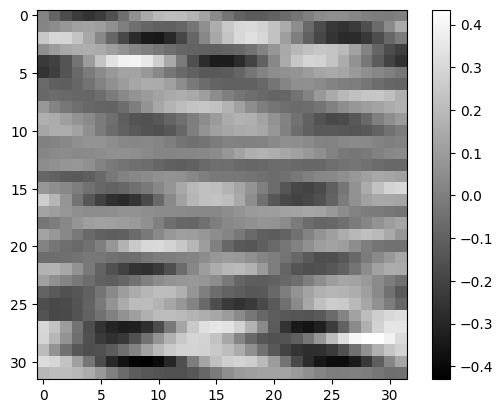

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 假設你的 numpy 陣列是 (32, 32) 的

# 顯示圖像
plt.imshow(data[3500], cmap='gray')
plt.colorbar()  # 顯示顏色條
plt.show()

## Train test split
Deep learning algorithms are data hungry. Their performance increases if those are trained on huge amounts of data. Case Western Bearing dataset is not a huge dataset. And the particular case that we are considering, there are only 4600 examples in total. We will keep the test set at 1000 examples which is slightly above 21%. The (80/20) splitting percentage of training and test set is some sort of convention in machine learning.

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 1000, random_state = 829, 
                                                                    stratify = labels)

In [13]:
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((3600, 32, 32), (1000, 32, 32), (3600,), (1000,))

In [14]:
train_labels[:3]

array([5, 0, 0], dtype=int8)

In [15]:
# reshape data
train_data = train_data.reshape(len(train_data),32,32,1)
test_data = test_data.reshape(len(test_data),32,32,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Shuffle data
index = np.random.permutation(len(train_labels))
trian_data, trian_labels = train_data[index], train_labels[index]

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(3600, 32, 32, 1) (3600, 10) (1000, 32, 32, 1) (1000, 10)


In [16]:
train_labels[:3]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Model
We will use the following model for classification. Details of model architecture is shown below.

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# 設定運算設備為 CPU
with tf.device('/CPU:0'):
    demo_model = Sequential([
        layers.Conv2D(32, 9, activation='relu', input_shape=(32, 32, 1)),
        layers.MaxPool2D(2),
        layers.Conv2D(32, 9, activation='relu'),
        layers.MaxPool2D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(96, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    demo_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), 
                  metrics= ['accuracy'])
    demo_model.summary()
    _loss, _accuracy = demo_model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)
    print("loss, accuracy=",_loss, _accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        2624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 32)          82976     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

2025-02-14 19:32:01.407296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 19:32:01.505892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 19:32:01.506222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-14 19:32:01.510132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

loss, accuracy= 2.337947130203247 0.10199999809265137


Deep learning model weights are initialized randomly. Due to inherent non-deterministic nature of processing, we will get different answers if we run the same model twice. The answers will also vary from computer to computer depending on architecture. The answers will also vary depending on software version. In our experiment we have used `Tensorflow-2.0.0`. So we have run the model 10 times and final result is the average of all. In the process we have also saved the best model. 

In [18]:
def create_compiled_model():
    model = Sequential([
    layers.Conv2D(32,9,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(32,9,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(96, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), 
                  metrics= ['accuracy'])
    return model

In [19]:
res = np.empty(10)
res[:] = np.nan
for i in range(10):
    model = create_compiled_model()
    history = model.fit(train_data, train_labels, epochs = 45, batch_size = 128, verbose = 0)    # Verbosity is set to zero
    res[i] = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)[1]            # Verbosity is set to zero
    print('Loop iteration %d, Accuracy: %4.4f' % (i+1, res[i]))
    if res[i]>=np.max(res[:(i+1)]):
        best_model = model

2025-02-14 19:32:20.112960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2025-02-14 19:32:22.584660: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb735c9de00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-14 19:32:22.584706: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-02-14 19:32:22.628304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-14 19:32:23.006720: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Loop iteration 1, Accuracy: 0.9870
Loop iteration 2, Accuracy: 0.9790
Loop iteration 3, Accuracy: 0.9900
Loop iteration 4, Accuracy: 0.9880
Loop iteration 5, Accuracy: 0.9870
Loop iteration 6, Accuracy: 0.9910
Loop iteration 7, Accuracy: 0.9890
Loop iteration 8, Accuracy: 0.9840
Loop iteration 9, Accuracy: 0.9840
Loop iteration 10, Accuracy: 0.9850


In [20]:
print('Average accuracy:%4.4f'%(np.mean(res))) # After running the model 10 times
print("Best accuracy: %4.4f"%(np.max(res)))
print("Worst accuracy: %4.4f"%(np.min(res)))
print('Standard deviation: %4.4f' % (np.std(res)))

Average accuracy:0.9864
Best accuracy: 0.9910
Worst accuracy: 0.9790
Standard deviation: 0.0034


## Saving the best model

It is very much likely that readers obtain different accuracy for each epoch and ultimately obtain a different final accuracy. And for complex models with more parameters, it might not be possible for all readers to train such a model from scratch using their personal computer (Some state of the art deep learning models developed by big tech companies take weeks or even months to train over multiple GPUs. It is not possible for an individual (including this author) to train such a model from beginning.) But this should not stop them from using the model to make predictions. For reproducibility of results and to help practitioners to use models, it is a common practice in deep learning community to share the trained model with all its weights  so that anyone can use it by downloading it. Following the same approach, we also make available the saved models so that anyone can use it and obtain the exact results as obtained by us. See [this notebook](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Using_saved_models_tensorflow.ipynb) describing steps to use pretrained models to obtain results. 

In [21]:
tf.keras.models.save_model(best_model, "saved_models/CWRU_CNN_raw_time_domain_data.h5")

## Evaluating using best model

In [22]:
test_data.shape

(1000, 32, 32, 1)

In [23]:
prediction = best_model.predict(test_data)
prediction

32/32 [==============================] - 0s 2ms/step


array([[2.2528079e-09, 2.5096217e-06, 9.9201971e-01, ..., 3.8298132e-11,
        7.9765925e-03, 4.2114191e-08],
       [3.3531070e-10, 9.9999249e-01, 7.5272219e-06, ..., 2.1398362e-18,
        1.4077989e-12, 1.4528247e-09],
       [4.4302444e-11, 1.1875375e-09, 4.0178979e-29, ..., 2.9244888e-23,
        7.7524535e-27, 8.6222300e-09],
       ...,
       [3.2348300e-31, 4.5224648e-13, 5.2245973e-22, ..., 3.3508686e-25,
        1.2294946e-24, 2.7396322e-08],
       [9.9977094e-01, 6.6017862e-15, 3.7302659e-13, ..., 3.1910751e-08,
        2.2901707e-04, 5.6929266e-09],
       [4.5905235e-14, 3.2078387e-07, 9.9993050e-01, ..., 1.3707719e-14,
        5.6062239e-05, 7.0259304e-10]], dtype=float32)

In [24]:
prediction.shape

(1000, 10)

In [25]:
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

In [26]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

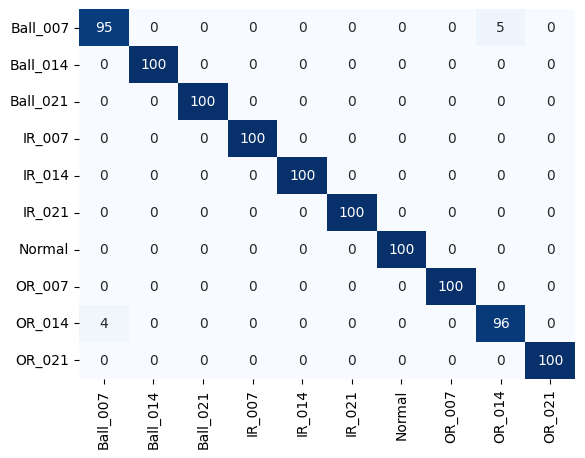

In [27]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
plt.xticks(rotation = 90)
plt.show()

The answers are really good, considering the fact that we have only used raw data as it is. We have done no preprocessing of the data. This approach is significantly different form the feature based approaches where we have to handcraft features beforehand before applying any machine learning algorithm. Finding those features often requires considerable domain expertise. In contrast, deep learning approaches need only data resizing (that is nothing).

**Note**: It is possible to improve on the results that we have shown by tweaking hyperparametes. So don't take these result as absolute best accuracy achievable. There is always room for improvement.

[For more results on both feature based methods and deep learning methods, visit my project page.](https://biswajitsahoo1111.github.io/cbm_codes_open/)

Last modified: 15 July, 2019

In [33]:
train_data.shape, train_labels.shape

((3600, 32, 32, 1), (3600, 10))

113/113 [==============================] - 0s 1ms/step


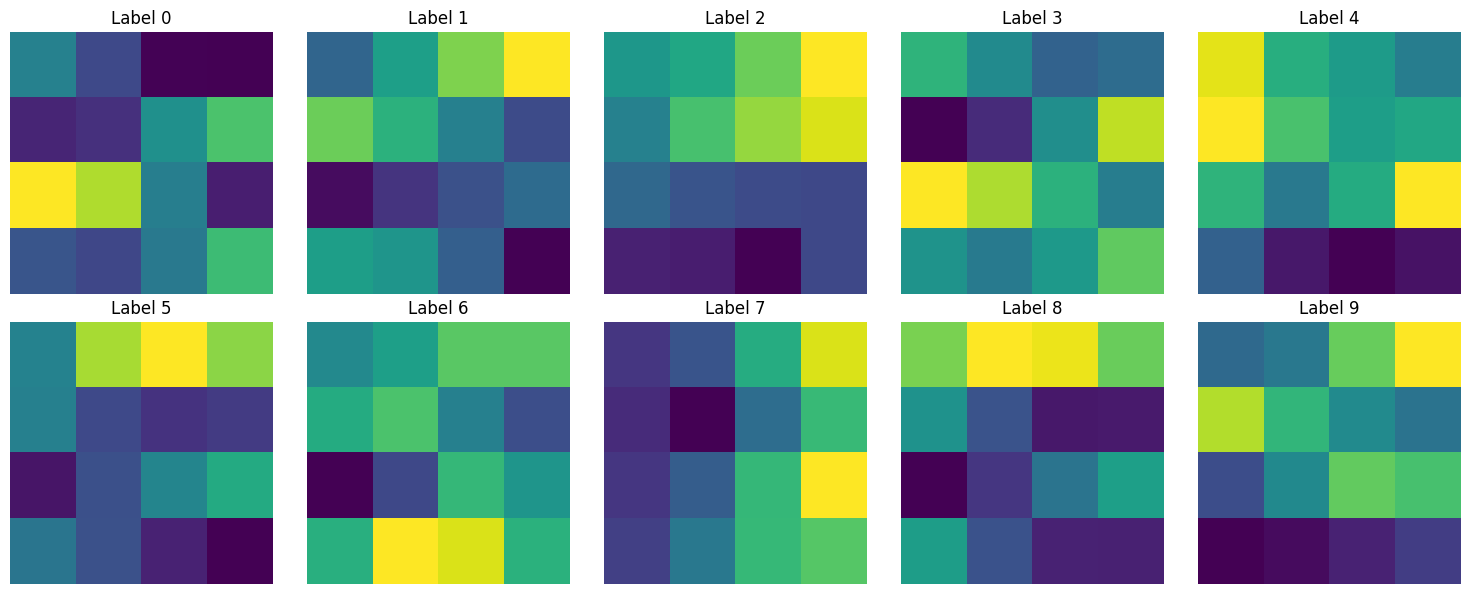

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Step 1: Create a model that outputs the second Conv2D layer (index 2)
intermediate_model = Model(inputs=best_model.input, outputs=best_model.layers[2].output)

# Step 2: Get the feature maps after the second Conv2D layer
feature_maps = intermediate_model.predict(train_data)

# Step 3: Calculate the average feature map per label
num_labels = 10  # You have 10 labels
average_feature_maps = []

for label in range(num_labels):
    # Get the indices of the samples belonging to the current label
    label_indices = np.argmax(train_labels, axis=1) == label
    label_feature_maps = feature_maps[label_indices]
    
    # Calculate the mean feature map for this label
    avg_map = np.mean(label_feature_maps, axis=0)
    average_feature_maps.append(avg_map)

# Step 4: Plot the average feature maps for each label
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 labels
axes = axes.flatten()

for i, avg_map in enumerate(average_feature_maps):
    ax = axes[i]
    ax.imshow(avg_map[..., 0], cmap='viridis')  # Show the first channel (if there are multiple)
    ax.set_title(f"Label {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

113/113 [==============================] - 0s 1ms/step


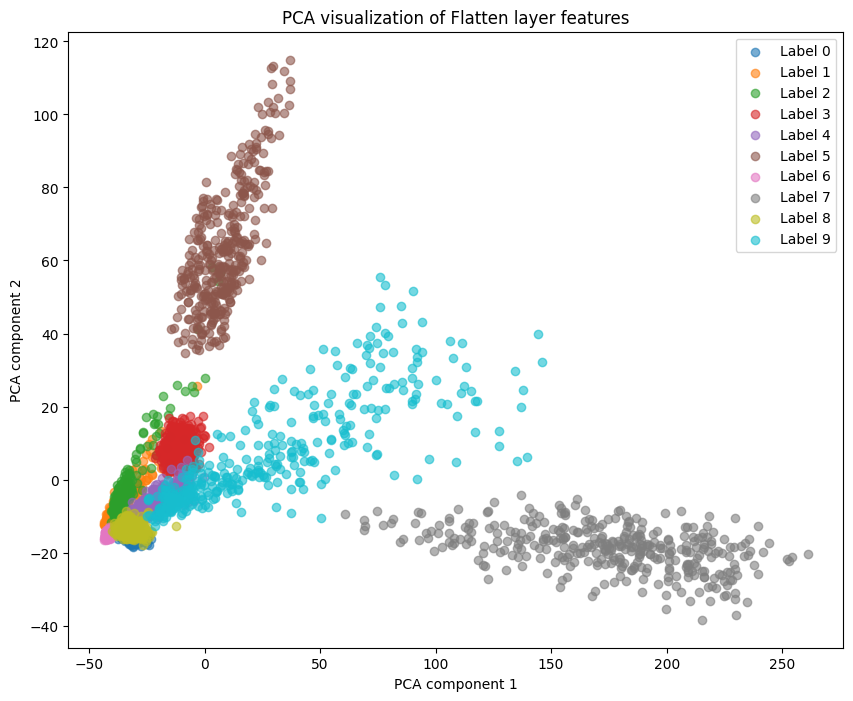

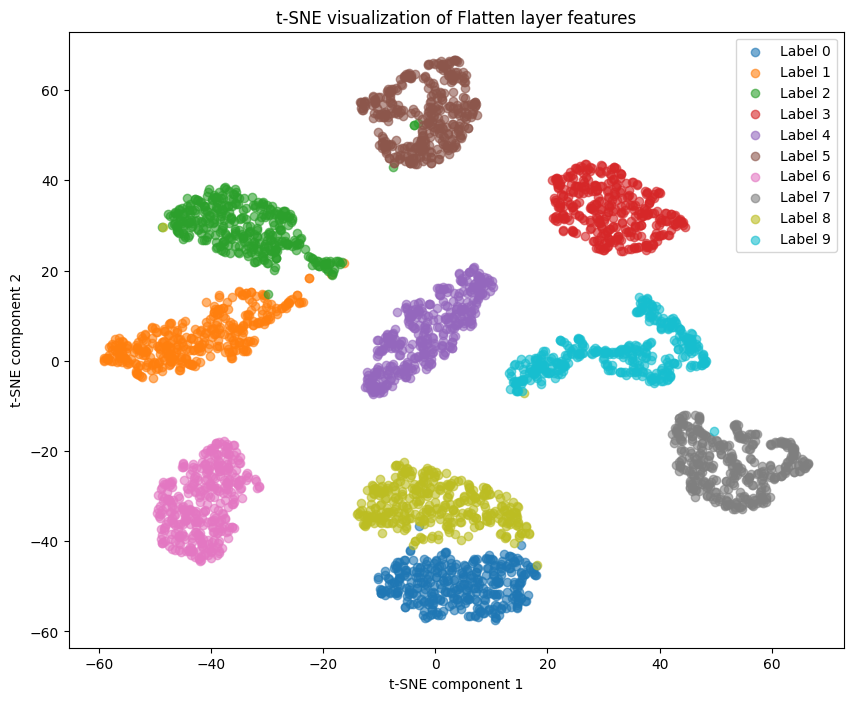

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model

# Step 1: Create a model that outputs the Flatten layer
intermediate_model = Model(inputs=best_model.input, outputs=best_model.layers[-4].output)

# Step 2: Get the feature map after the Flatten layer
flattened_features = intermediate_model.predict(train_data)

# --- PCA Visualization ---
# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
pca_features = pca.fit_transform(flattened_features)

plt.figure(figsize=(10, 8))
for label in range(10):  # Assuming 10 labels
    indices = np.argmax(train_labels, axis=1) == label
    plt.scatter(pca_features[indices, 0], pca_features[indices, 1], label=f'Label {label}', alpha=0.6)

plt.title('PCA visualization of Flatten layer features')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()
plt.show()

# --- t-SNE Visualization ---
# First, apply PCA to reduce the dimensions to 50
pca_50 = PCA(n_components=50)
pca_features_50 = pca_50.fit_transform(flattened_features)

# Now, apply t-SNE to reduce to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features_50)

plt.figure(figsize=(10, 8))
for label in range(10):  # Assuming 10 labels
    indices = np.argmax(train_labels, axis=1) == label
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=f'Label {label}', alpha=0.6)

plt.title('t-SNE visualization of Flatten layer features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()

113/113 [==============================] - 0s 1ms/step


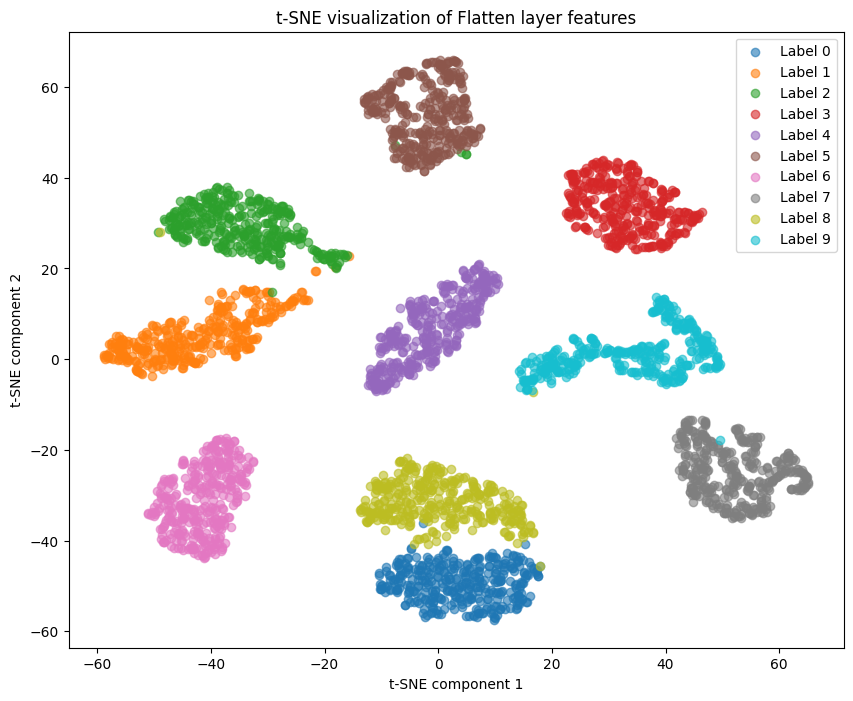

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model

# Step 1: Create a model that outputs the Flatten layer
intermediate_model = Model(inputs=best_model.input, outputs=best_model.layers[-4].output)

# Step 2: Get the feature map after the Flatten layer
flattened_features = intermediate_model.predict(train_data)

# Step 3: Apply PCA to reduce the dimensions to 50
pca = PCA(n_components=50)
pca_features = pca.fit_transform(flattened_features)

# Step 4: Apply t-SNE to reduce to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

# Step 5: Visualize the t-SNE result
plt.figure(figsize=(10, 8))
for label in range(10):  # Assuming 10 labels
    indices = np.argmax(train_labels, axis=1) == label
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=f'Label {label}', alpha=0.6)

plt.title('t-SNE visualization of Flatten layer features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()